In [137]:
import numpy as np
import pandas as pd
import urllib
import os
import re
import pickle
import nltk
import string
import time
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import RegexpTokenizer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from collections import Counter
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, recall_score, auc, roc_auc_score, roc_curve, precision_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

from mlxtend.plotting import plot_confusion_matrix
from scikitplot.metrics import plot_cumulative_gain, plot_precision_recall, plot_roc_curve
PROJECT_ROOT_DIR = ".."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
np.random.seed(42)

def save_fig(title):
    path = os.path.join(IMAGES_PATH, title + ".png")
    plt.tight_layout()
    plt.savefig(path, format="png", dpi=300)

In [10]:
def loadFile(name):
    directory = str(os.getcwd())
    filepath = os.path.join(directory, name)
    with open(filepath,'r') as f:
        data = f.readlines()
    data = list(set(data))
    result = []
    for d in data:
        d = str(urllib.parse.unquote(d))
        result.append(d)
    return result

In [11]:
badQueries = loadFile("../datasets/badqueries.txt")
goodQueries = loadFile("../datasets/goodqueries.txt")

In [12]:
bad_df = pd.DataFrame(badQueries)
good_df = pd.DataFrame(goodQueries)

In [13]:
bad_df.columns = ["query"]
good_df.columns = ["query"]

In [14]:
bad_df.head()

,query
0,/fpnpp5zg.cfc?<meta http-equiv=set-cookie cont...
1,/cgi-bin/starnet/addons/slideshow_full.php?alb...
2,\n str=$(echo JADKKF)\n str1=${#str}\n if [ 5 ...
3,/n1afe1y6.idc?<script>cross_site_scripting.nas...
4,/ewc3rz1l.do?<meta http-equiv=set-cookie conte...


In [15]:
good_df.head()

,query
0,/readingfeat/\n
1,/header_title/\n
2,/cgi-bin/wrap\n
3,/ta4tijjd071ghdo4v/\n
4,/245437/\n


In [16]:
text = good_df.loc[0].str
text = text[:-2]
text

query    /readingfeat
Name: 0, dtype: object

In [17]:
def clean_newline(column):
    column[:-2]
    return column[:-2]

In [18]:
good_df["query"] = good_df["query"].apply(clean_newline)

In [19]:
good_df.head()

,query
0,/readingfeat
1,/header_title
2,/cgi-bin/wra
3,/ta4tijjd071ghdo4v
4,/245437


In [20]:
bad_df["query"] = bad_df["query"].apply(clean_newline)

In [21]:
bad_df.head()

,query
0,/fpnpp5zg.cfc?<meta http-equiv=set-cookie cont...
1,/cgi-bin/starnet/addons/slideshow_full.php?alb...
2,\n str=$(echo JADKKF)\n str1=${#str}\n if [ 5 ...
3,/n1afe1y6.idc?<script>cross_site_scripting.nas...
4,/ewc3rz1l.do?<meta http-equiv=set-cookie conte...


In [22]:
good_df["label"] = 0
bad_df["label"] = 1

In [23]:
good_df.shape[0] + bad_df.shape[0]

1310707

In [24]:
df = pd.concat([good_df, bad_df], axis=0)

In [25]:
df.shape[0]

1310707

In [26]:
df.head()

,query,label
0,/readingfeat,0
1,/header_title,0
2,/cgi-bin/wra,0
3,/ta4tijjd071ghdo4v,0
4,/245437,0


In [27]:
df = df.sample(frac=1).reset_index(drop=True)

In [28]:
df.head()

,query,label
0,/komport,0
1,/qlaunch,0
2,/nowi_uzytkownicy1,0
3,/118438,0
4,/mainfrme,0


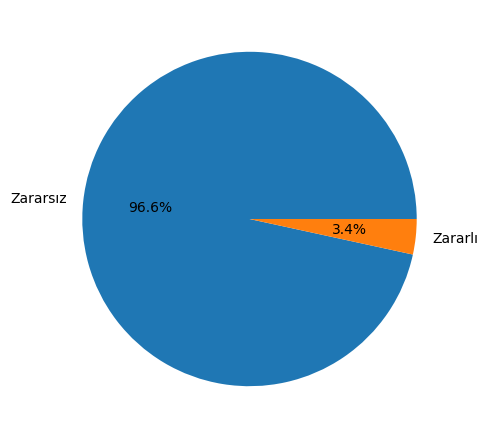

In [165]:
total_0, total_1 = len(df[df["label"] == 0]), len(df[df["label"] == 1])
label = np.array(["Zararsız", "Zararlı"])
values = np.array([total_0, total_1])
plt.figure(figsize=(5, 5))
plt.pie(values, labels=label, autopct="%.1f%%")
save_fig("total_db")
plt.show()

In [30]:
def clear_first_char(column):
    if column.startswith("/"):
        return column[1:]
    else:
        return column

In [31]:
df["query"] = df["query"].apply(clear_first_char)

In [32]:
df.head()

,query,label
0,komport,0
1,qlaunch,0
2,nowi_uzytkownicy1,0
3,118438,0
4,mainfrme,0


# Preprocess

In [33]:
def xss_check(input_string):
    xss_pattern=re.compile(r'(<|>|&lt;|&gt;|script|alert|document\.|onload\=|onerror\=|eval\(|expression\(|prompt\(|confirm\()')
    if xss_pattern.search(input_string.split("/")[-1]):
        return 1
    else:
        return 0

In [34]:
df["is_xss"] = df["query"].apply(xss_check)

In [35]:
df[df["is_xss"] == 1].head()

,query,label,is_xss
47,7dbjwpw6.idc?<script>cross_site_scripting.nasl...,1,1
124,"downloads/pafiledb.php?action=rate&id=4?\""&lt;...",1,1
200,"nuh3zirz.cfc?<img src=""javascript:alert(cross_...",1,1
289,"help.php?q=""\x0duname >q66781813",1,1
460,"1qwv2p5p.htm?<script>document.cookie=""testvqcy...",1,1


In [36]:
def lfi_check(input_string):
    lfi_pattern = re.compile(r'(file\:\/\/|(\.\.\/)|(\.\.\\))')
    if "=" in input_string.split("/")[-1]:
        if lfi_pattern.search(input_string.split("/")[-1].split("=", 1)[1]):
            return 1
        else:
            return 0
    elif lfi_pattern.search(input_string.split("/")[-1]):
        return 1
    else:
        return 0

In [37]:
"scripts/misc/audio.php?recording=../version.in".split("=", 1)

['scripts/misc/audio.php?recording', '../version.in']

In [38]:
df["is_lfi"] = df["query"].apply(lfi_check)

In [39]:
df[df["is_lfi"] == 1].sample(5)

,query,label,is_xss,is_lfi
703237,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,1,0,1
37920,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,1,0,1
892991,/..\/..\/..\/..\/..\/..\{FILE,1,0,1
1109381,\..\..\..\..\winnt\win.in,1,0,1
1041835,\..\..\..\..\..\..\..\..\..\..\etc\passw,1,0,1


In [40]:
def command_injection_check(input_string):
    cmd_injection_pattern = re.compile(r'(;|\||`|\$\(|\$\{)')

    if cmd_injection_pattern.search(input_string):
        return 1
    else:
        return 0

In [41]:
df["is_oci"] = df["query"].apply(command_injection_check)

In [42]:
df[df["is_oci"] == 1].sample(5)

,query,label,is_xss,is_lfi,is_oci
473419,"i2n4v4rl.mscgi?<img src=""javascript:alert(cros...",1,1,0,1
320211,"5o9zq43e.php?<img src=""javascript:alert(cross_...",1,1,0,1
1024463,cgi-local/fileseek.cgi?foot=&head=;cat /etc/pa...,1,0,0,1
683178,"""&echo$IFSHAWFWE$((23+63))$(echo$IFSHAWFWE)HAW...",1,0,0,1
862260,"ju0u7kfo.pl?<img src=""javascript:alert(cross_s...",1,1,0,1


In [43]:
def sql_injection_check(input_string):
    sqli_pattern = re.compile(r'(\b(SELECT|INSERT|UPDATE|DELETE|FROM|WHERE|AND|OR|UNION|ALL|EXEC|EXECUTE|DECLARE|CAST)\b)')

    if sqli_pattern.search(input_string):
        return 1
    else:
        return 0

In [44]:
df["is_sqli"] = df["query"].apply(sql_injection_check)

In [45]:
df[df["is_sqli"] == 1].sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli
390413,' OR '1'='1',1,0,0,0,1
948992,IF(7423=7424) SELECT 7423 ELSE DROP FUNCTION x...,1,0,0,0,1
1101166,AND 1=1 AND '%'=,1,0,0,0,1
764574,"23'#DDvIMgC\nLIMIT#wyQDiZxbEfWH\n1,1#vJHSbhW\n...",1,0,0,0,1
831228,x' AND 1=(SELECT COUNT(*) FROM tabname); -,1,0,0,1,1


In [46]:
def urllen(url):
    return len(url)

In [47]:
df["url_len"] = df["query"].apply(urllen)

In [48]:
df.head()

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len
0,komport,0,0,0,0,0,7
1,qlaunch,0,0,0,0,0,7
2,nowi_uzytkownicy1,0,0,0,0,0,17
3,118438,0,0,0,0,0,6
4,mainfrme,0,0,0,0,0,8


In [49]:
def semicolon_count(url):
    return url.count(";")

In [50]:
df["semicolon_count"] = df["query"].apply(semicolon_count)

In [51]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count
157660,javascript/packed.w,0,0,0,0,0,19,0
1281294,juiced-hoodlum_passworded,0,0,0,0,0,25,0
857997,javascript/conference.da,0,0,0,0,0,24,0
961919,goodwill_480x376,0,0,0,0,0,16,0
960629,pet-bullet,0,0,0,0,0,10,0


In [52]:
def underscore_count(url):
    return url.count("_")

In [53]:
df["underscore_count"] = df["query"].apply(underscore_count)

In [54]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count
725397,javascript/test.tx,0,0,0,0,0,18,0,0
271158,javascript/tracker.s,0,0,0,0,0,20,0,0
654145,javascript/lost.ja,0,0,0,0,0,18,0,0
101491,snowcyy2005240fl3jd6,0,0,0,0,0,20,0,0
1108223,000116698,0,0,0,0,0,9,0,0


In [55]:
def questionmark_count(url):
    return url.count("?")

In [56]:
df["questionmark_count"] = df["query"].apply(questionmark_count)

In [57]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count
633553,javascript/hardcore.tar.bz,0,0,0,0,0,26,0,0,0
251797,msg02430,0,0,0,0,0,8,0,0,0
199599,sarkblog,0,0,0,0,0,8,0,0,0
913362,ah my goddess,0,0,0,0,0,13,0,0,0
477128,tlbtld-small,0,0,0,0,0,12,0,0,0


In [58]:
def equal_count(url):
    return url.count("=")

In [59]:
df["equal_count"] = df["query"].apply(equal_count)

In [60]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,equal_count
954418,javascript/tape.cor,0,0,0,0,0,19,0,0,0,0
1142654,snapshot_016,0,0,0,0,0,12,0,1,0,0
140872,govwide,0,0,0,0,0,7,0,0,0,0
1127806,dl7137,0,0,0,0,0,6,0,0,0,0
1095815,415_ss,0,0,0,0,0,6,0,1,0,0


In [61]:
def and_count(url):
    return url.count("&")

In [62]:
df["and_count"] = df["query"].apply(equal_count)

In [63]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,equal_count,and_count
285381,dvd150,0,0,0,0,0,6,0,0,0,0,0
364510,100x1002,0,0,0,0,0,8,0,0,0,0,0
500013,ferro-racer,0,0,0,0,0,11,0,0,0,0,0
959049,globalservices,0,0,0,0,0,14,0,0,0,0,0
932786,103369,0,0,0,0,0,6,0,0,0,0,0


In [64]:
def or_count(url):
    return url.count("|")

In [65]:
df["or_count"] = df["query"].apply(or_count)

In [66]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count
1111355,sarah blasko - the overture and the underscore,0,0,0,0,0,46,0,0,0,0,0,0
469666,ezkey06,0,0,0,0,0,7,0,0,0,0,0,0
1050740,image0291101987058723,0,0,0,0,0,21,0,0,0,0,0,0
259901,tn_4811,0,0,0,0,0,7,0,1,0,0,0,0
33088,gumpbranches,0,0,0,0,0,12,0,0,0,0,0,0


In [67]:
df.head()

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count
0,komport,0,0,0,0,0,7,0,0,0,0,0,0
1,qlaunch,0,0,0,0,0,7,0,0,0,0,0,0
2,nowi_uzytkownicy1,0,0,0,0,0,17,0,1,0,0,0,0
3,118438,0,0,0,0,0,6,0,0,0,0,0,0
4,mainfrme,0,0,0,0,0,8,0,0,0,0,0,0


In [68]:
def dotcount(url):
    return url.count(".")

In [69]:
df["dot_count"] = df["query"].apply(dotcount)

In [70]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count,dot_count
1035979,2163355,0,0,0,0,0,7,0,0,0,0,0,0,0
742407,handmark hearts and spades 1,0,0,0,0,0,28,0,0,0,0,0,0,0
306732,pcimprovement,0,0,0,0,0,13,0,0,0,0,0,0,0
380159,99794641,0,0,0,0,0,8,0,0,0,0,0,0,0
1275107,include/pear/it.php?basepath=@rfiur,0,0,0,0,0,35,0,0,1,1,1,0,1


In [71]:
def atcount(url):
    return url.count("@")

In [72]:
df["at_count"] = df["query"].apply(atcount)

In [73]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count,dot_count,at_count
1010013,dff_php_frameworkapi-latest/include/dff_mer_pr...,0,0,0,0,0,108,0,6,1,1,1,0,4,0
1187764,may18hb,0,0,0,0,0,7,0,0,0,0,0,0,0,0
1115217,javascript/uploads.cs,0,0,0,0,0,21,0,0,0,0,0,0,1,0
892462,es_catalog,0,0,0,0,0,10,0,1,0,0,0,0,0,0
1200042,2608244,0,0,0,0,0,7,0,0,0,0,0,0,0,0


In [74]:
def subdircount(url):
    parsed_url = urllib.parse.urlparse(url)
    subdirectory_path = len(parsed_url.path.strip("/").split("/"))
    return subdirectory_path

In [75]:
df["subdir_count"] = df["query"].apply(subdircount)

In [76]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count,dot_count,at_count,subdir_count
978977,arab3upload/customize.php?path=http://192.168....,0,0,0,0,0,81,0,0,3,2,2,0,4,0,2
246815,anagramix,0,0,0,0,0,9,0,0,0,0,0,0,0,0,1
131472,muslims,0,0,0,0,0,7,0,0,0,0,0,0,0,0,1
819571,ps0412161905,0,0,0,0,0,12,0,0,0,0,0,0,0,0,1
119843,710187,0,0,0,0,0,6,0,0,0,0,0,0,0,0,1


In [77]:
def query_len(url):
    parsed_url = urllib.parse.urlparse(url)
    if len(parsed_url.query) > 0:
        query_params = urllib.parse.parse_qs(parsed_url.query)
        query_string = "".join(f"{value[0]}" for key, value in query_params.items())    
        return len(query_string)
    else:
        return 0

In [78]:
df["query_len"] = df["query"].apply(query_len)

In [79]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count,dot_count,at_count,subdir_count,query_len
899957,hu-flag,0,0,0,0,0,7,0,0,0,0,0,0,0,0,1,0
1264457,50403000000050a03046674600000010d6a01047000000...,0,0,0,0,0,122,0,0,0,0,0,0,0,0,1,0
1153108,100million,0,0,0,0,0,10,0,0,0,0,0,0,0,0,1,0
113588,autostartviewer,0,0,0,0,0,15,0,0,0,0,0,0,0,0,1,0
883489,javascript/cgi-sys.ex,1,0,0,0,0,21,0,0,0,0,0,0,1,0,2,0


In [80]:
def param_count(url):
    parsed_url = urllib.parse.urlparse(url)
    query_params = urllib.parse.parse_qs(parsed_url.query)
    return len(query_params)

In [81]:
df["param_count"] = df["query"].apply(param_count)

In [82]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count,dot_count,at_count,subdir_count,query_len,param_count
720129,startpagina_b,0,0,0,0,0,13,0,1,0,0,0,0,0,0,1,0,0
945704,davidoff-classic_adv,0,0,0,0,0,20,0,1,0,0,0,0,0,0,1,0,0
586582,000085863,0,0,0,0,0,9,0,0,0,0,0,0,0,0,1,0,0
1195552,msg28852,0,0,0,0,0,8,0,0,0,0,0,0,0,0,1,0,0
708232,396092,0,0,0,0,0,6,0,0,0,0,0,0,0,0,1,0,0


In [83]:
def total_digits_in_url(url):
    total_digits = 0
    for text in list(map(str, "0123456789")):
        total_digits += url.lower().count(text)
        
    return total_digits

In [84]:
df["total_digits_url"] = df["query"].apply(total_digits_in_url)

In [85]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count,dot_count,at_count,subdir_count,query_len,param_count,total_digits_url
828889,javascript/1992.in,0,0,0,0,0,18,0,0,0,0,0,0,1,0,2,0,0,4
1210948,schoolbuilding,0,0,0,0,0,14,0,0,0,0,0,0,0,0,1,0,0,0
339828,maxschube,0,0,0,0,0,9,0,0,0,0,0,0,0,0,1,0,0,0
1183380,wizomontreal98,0,0,0,0,0,14,0,0,0,0,0,0,0,0,1,0,0,2
28729,examples/jsp/security/protected/is_cgi_install...,0,0,0,0,0,79,0,5,0,0,0,0,1,0,5,0,0,12


In [86]:
def total_letter_in_url(url):
    total_letter = 0
    for text in url:
        if text not in "0123456789":
            if text not in string.punctuation:
                total_letter += 1
        
    return total_letter

In [87]:
df["total_letter_url"] = df["query"].apply(total_letter_in_url)

In [88]:
tokenizer = RegexpTokenizer(r"[A-Za-z]+")

In [89]:
df["url_tokenized"] = df["query"].apply(lambda x: tokenizer.tokenize(x))

In [90]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,...,and_count,or_count,dot_count,at_count,subdir_count,query_len,param_count,total_digits_url,total_letter_url,url_tokenized
182890,gr016060,0,0,0,0,0,8,0,0,0,...,0,0,0,0,1,0,0,6,2,[gr]
637556,besttop,0,0,0,0,0,7,0,0,0,...,0,0,0,0,1,0,0,0,7,[besttop]
410347,abavlockyerdocdfibrief2,0,0,0,0,0,23,0,0,0,...,0,0,0,0,1,0,0,1,22,[abavlockyerdocdfibrief]
1225996,1129048331_673,0,0,0,0,0,14,0,1,0,...,0,0,0,0,1,0,0,13,0,[]
648536,laroncourt,0,0,0,0,0,10,0,0,0,...,0,0,0,0,1,0,0,0,10,[laroncourt]


In [91]:
stemmer = SnowballStemmer("english")

In [92]:
def stem_url(column):
    words = [stemmer.stem(word) for word in column if len(word) >= 3]
    return " ".join(words)

In [93]:
df["url_stemmed"] = df["url_tokenized"].apply(stem_url)

In [94]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,...,or_count,dot_count,at_count,subdir_count,query_len,param_count,total_digits_url,total_letter_url,url_tokenized,url_stemmed
623338,exhibit1,0,0,0,0,0,8,0,0,0,...,0,0,0,1,0,0,1,7,[exhibit],exhibit
312051,avds_contact,0,0,0,0,0,12,0,1,0,...,0,0,0,1,0,0,0,11,"[avds, contact]",avd contact
525956,nbcnewsradio,0,0,0,0,0,12,0,0,0,...,0,0,0,1,0,0,0,12,[nbcnewsradio],nbcnewsradio
164062,serialdslrcontrol,0,0,0,0,0,17,0,0,0,...,0,0,0,1,0,0,0,17,[serialdslrcontrol],serialdslrcontrol
466512,"rpxyx07v.kspx?<script>document.cookie=""testbnl...",1,1,0,1,0,62,1,0,1,...,0,2,0,1,24,1,6,44,"[rpxyx, v, kspx, script, document, cookie, tes...",rpxyx kspx script document cooki testbn script


In [95]:
def total_digits_domain(url):
    parsed_url = urllib.parse.urlparse(url)
    clean_url = url.replace(parsed_url.query, "")
    path_components = [component for component in clean_url.split('/') if component]
    if path_components:
        until_last_directory = "".join([word for word in path_components[:-1]])
        return total_digits_in_url(until_last_directory)
    else:
        return 0

In [96]:
df["total_digits_domain"] = df["query"].apply(total_digits_domain)

In [97]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,...,dot_count,at_count,subdir_count,query_len,param_count,total_digits_url,total_letter_url,url_tokenized,url_stemmed,total_digits_domain
358859,javascript/proto.manifes,0,0,0,0,0,24,0,0,0,...,1,0,2,0,0,0,22,"[javascript, proto, manifes]",javascript proto manif,0
206801,861894,0,0,0,0,0,6,0,0,0,...,0,0,1,0,0,6,0,[],,0
505835,btn_master-degrees,0,0,0,0,0,18,0,1,0,...,0,0,1,0,0,0,16,"[btn, master, degrees]",btn master degre,0
235112,burkey,0,0,0,0,0,6,0,0,0,...,0,0,1,0,0,0,6,[burkey],burkey,0
741301,120x60-3,0,0,0,0,0,8,0,0,0,...,0,0,1,0,0,6,1,[x],,0


In [98]:
def total_letter_domain(url):
    parsed_url = urllib.parse.urlparse(url)
    clean_url = url.replace(parsed_url.query, "")
    path_components = [component for component in clean_url.split('/') if component]
    if path_components:
        until_last_directory = "".join([word for word in path_components[:-1]])
        return total_letter_in_url(until_last_directory)
    else:
        return 0

In [99]:
df["total_letter_domain"] = df["query"].apply(total_letter_domain)

In [100]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,...,at_count,subdir_count,query_len,param_count,total_digits_url,total_letter_url,url_tokenized,url_stemmed,total_digits_domain,total_letter_domain
969384,94camryremote,0,0,0,0,0,13,0,0,0,...,0,1,0,0,2,11,[camryremote],camryremot,0,0
20063,0399153233,0,0,0,0,0,10,0,0,0,...,0,1,0,0,10,0,[],,0,0
905465,board construction georgia industry licensing,0,0,0,0,0,45,0,0,0,...,0,1,0,0,0,45,"[board, construction, georgia, industry, licen...",board construct georgia industri licens,0,0
317302,health_com,0,0,0,0,0,10,0,1,0,...,0,1,0,0,0,9,"[health, com]",health com,0,0
901950,javascript/crossdomain.do,0,0,0,0,0,25,0,0,0,...,0,2,0,0,0,23,"[javascript, crossdomain, do]",javascript crossdomain,0,10


In [101]:
def total_digits_path(url):
    parsed_url = urllib.parse.urlparse(url)
    clean_url = url.replace(parsed_url.query, "")
    path_components = [component for component in clean_url.split('/') if component]
    if path_components:
        last_directory = "".join([word for word in path_components[-1]])
        return total_digits_in_url(last_directory)
    else:
        return total_digits_in_url(clean_url)

In [102]:
df["total_digits_path"] = df["query"].apply(total_digits_path)

In [103]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,...,subdir_count,query_len,param_count,total_digits_url,total_letter_url,url_tokenized,url_stemmed,total_digits_domain,total_letter_domain,total_digits_path
477642,vwshowsurvey,0,0,0,0,0,12,0,0,0,...,1,0,0,0,12,[vwshowsurvey],vwshowsurvey,0,0,0
279923,examples/servlets/servlet/manager,0,0,0,0,0,33,0,0,0,...,4,0,0,0,30,"[examples, servlets, servlet, manager]",exampl servlet servlet manag,0,23,0
380607,robert gustavsson som peps - svcd,0,0,0,0,0,33,0,0,0,...,1,0,0,0,32,"[robert, gustavsson, som, peps, svcd]",robert gustavsson som pep svcd,0,0,0
1242200,javascript/show_post.xs,0,0,0,0,0,23,0,1,0,...,2,0,0,0,20,"[javascript, show, post, xs]",javascript show post,0,10,0
201454,msg327248,0,0,0,0,0,9,0,0,0,...,1,0,0,6,3,[msg],msg,0,0,6


In [104]:
def total_letter_path(url):
    parsed_url = urllib.parse.urlparse(url)
    clean_url = url.replace(parsed_url.query, "")
    path_components = [component for component in clean_url.split('/') if component]
    if path_components:
        last_directory = "".join([word for word in path_components[-1]])
        return total_letter_in_url(last_directory)
    else:
        return total_letter_in_url(clean_url)

In [105]:
df["total_letter_path"] = df["query"].apply(total_letter_path)

In [106]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,...,query_len,param_count,total_digits_url,total_letter_url,url_tokenized,url_stemmed,total_digits_domain,total_letter_domain,total_digits_path,total_letter_path
459991,emailimage2,0,0,0,0,0,11,0,0,0,...,0,0,1,10,[emailimage],emailimag,0,0,1,10
1117157,storyreader$6917,0,0,0,0,0,16,0,0,0,...,0,0,4,11,[storyreader],storyread,0,0,4,11
1029453,msg08109,0,0,0,0,0,8,0,0,0,...,0,0,5,3,[msg],msg,0,0,5,3
710278,358601,0,0,0,0,0,6,0,0,0,...,0,0,6,0,[],,0,0,6,0
308896,168479,0,0,0,0,0,6,0,0,0,...,0,0,6,0,[],,0,0,6,0


In [107]:
def has_extension(url):
    parsed_url = urllib.parse.urlparse(url)
    query_params = urllib.parse.parse_qs(parsed_url.query)
    path = parsed_url.path
    file_extension = os.path.splitext(path)[1]
    if not query_params or not file_extension:
        return 0
    else:
        return 1

In [108]:
df["has_extension"] = df["query"].apply(has_extension)

In [109]:
df[df["has_extension"] == 1].sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,...,param_count,total_digits_url,total_letter_url,url_tokenized,url_stemmed,total_digits_domain,total_letter_domain,total_digits_path,total_letter_path,has_extension
273056,account.php?inspath=@rfiur,0,0,0,0,0,26,0,0,1,...,1,0,22,"[account, php, inspath, rfiur]",account php inspath rfiur,0,0,0,10,1
659141,admin/components/com_fm/fm.install.php?lm_abso...,1,0,0,0,0,118,0,4,2,...,2,16,71,"[admin, components, com, fm, fm, install, php,...",admin compon com instal php absolut path insta...,0,20,0,12,1
886747,"main.php?stuff=""&rm\xa0q65461871&rem\xa",1,0,0,0,0,39,0,0,1,...,1,9,22,"[main, php, stuff, rm, xa, q, rem, xa]",main php stuff rem,0,0,0,7,1
805145,xlj7h65o.nsf?<meta http-equiv=set-cookie conte...,1,1,0,0,0,63,0,0,1,...,1,6,47,"[xlj, h, o, nsf, meta, http, equiv, set, cooki...",xlj nsf meta http equiv set cooki content testtbb,0,0,3,8,1
974635,wordpress/wp-content/plugins/sniplets/modules/...,0,0,0,0,0,117,0,1,2,...,1,17,81,"[wordpress, wp, content, plugins, sniplets, mo...",wordpress content plugin sniplet modul syntax ...,0,40,0,18,1


In [110]:
def find_extension(url):
    parsed_url = urllib.parse.urlparse(url)
    query_params = urllib.parse.parse_qs(parsed_url.query)
    path = parsed_url.path
    file_extension = os.path.splitext(path)[1]
    if not file_extension:
        return ""
    else:
        return file_extension

In [111]:
df["extension"] = df["query"].apply(find_extension)

In [112]:
df[df["has_extension"] == 1].sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,...,total_digits_url,total_letter_url,url_tokenized,url_stemmed,total_digits_domain,total_letter_domain,total_digits_path,total_letter_path,has_extension,extension
873126,sources/misc/new_day.php?path=http://192.168.2...,0,0,0,0,0,64,0,1,1,...,17,33,"[sources, misc, new, day, php, path, http, ghl...",sourc misc new day php path http ghl,0,11,0,9,1,.php
213803,script/ident/loginmodif.php?path_inc=@rfiur,1,0,0,0,0,43,0,1,1,...,0,36,"[script, ident, loginmodif, php, path, inc, rf...",script ident loginmodif php path inc rfiur,0,11,0,13,1,.php
635233,pollit/poll_it_ssi_v2.0.cgi?data_dir=/etc/pass...,1,0,0,0,0,51,0,4,1,...,3,36,"[pollit, poll, it, ssi, v, cgi, data, dir, etc...",pollit poll ssi cgi data dir etc passwd,0,6,2,13,1,.cgi
1192945,editsite.php?returnpath=http://192.168.202.96:...,0,0,0,0,0,64,0,0,1,...,16,37,"[editsite, php, returnpath, http, no, ghqiguzhst]",editsit php returnpath http ghqiguzhst,0,0,0,11,1,.php
265337,inc/config.inc.php?x[1]=http://192.168.202.96:...,0,0,0,0,0,65,0,0,1,...,18,32,"[inc, config, inc, php, x, http, dckqcc, acprbz]",inc config inc php http dckqcc acprbz,0,3,0,12,1,.php


In [113]:
def has_parameter(url):
    parsed_url = urllib.parse.urlparse(url)
    if len(parsed_url.query) > 0:
        return 1
    else:
        return 0

In [114]:
df["has_parameter"] = df["query"].apply(has_parameter)

In [115]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,...,total_letter_url,url_tokenized,url_stemmed,total_digits_domain,total_letter_domain,total_digits_path,total_letter_path,has_extension,extension,has_parameter
51219,javascript/windows.tem,0,0,0,0,0,22,0,0,0,...,20,"[javascript, windows, tem]",javascript window tem,0,10,0,10,0,.tem,0
893286,desktopmanager-0,0,0,0,0,0,16,0,0,0,...,14,[desktopmanager],desktopmanag,0,0,1,14,0,,0
820422,173042,0,0,0,0,0,6,0,0,0,...,0,[],,0,0,6,0,0,,0
643162,javascript/ls.cs,0,0,0,0,0,16,0,0,0,...,14,"[javascript, ls, cs]",javascript,0,10,0,4,0,.cs,0
1240914,rmenterprise,0,0,0,0,0,12,0,0,0,...,12,[rmenterprise],rmenterpris,0,0,0,12,0,,0


In [116]:
def find_parameter_name(url):
    parsed_url = urllib.parse.urlparse(url)
    if len(parsed_url.query) > 0:
        query_params = urllib.parse.parse_qs(parsed_url.query)
        query_string = " ".join(f"{key}" for key, value in query_params.items())    
        return query_string
    else:
        return ""

In [117]:
df["parameters"] = df["query"].apply(find_parameter_name)

In [118]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,...,url_tokenized,url_stemmed,total_digits_domain,total_letter_domain,total_digits_path,total_letter_path,has_extension,extension,has_parameter,parameters
440109,647220,0,0,0,0,0,6,0,0,0,...,[],,0,0,6,0,0,,0,
656215,467000-467999,0,0,0,0,0,13,0,0,0,...,[],,0,0,12,0,0,,0,
1001998,files/amazon-bestsellers.php?carppath=http://1...,0,0,0,0,0,80,0,0,1,...,"[files, amazon, bestsellers, php, carppath, ht...",file amazon bestsel php carppath http moclyxlw...,0,5,0,20,1,.php,1,carppath
146147,typepadfeaturedblogs,0,0,0,0,0,20,0,0,0,...,[typepadfeaturedblogs],typepadfeaturedblog,0,0,0,20,0,,0,
714250,errors/configmode.php?gallery_basedir=http://1...,0,0,0,0,0,78,0,1,1,...,"[errors, configmode, php, gallery, basedir, ht...",error configmod php galleri basedir http llumt...,0,6,0,13,1,.php,1,gallery_basedir


In [119]:
df.columns

Index(['query', 'label', 'is_xss', 'is_lfi', 'is_oci', 'is_sqli', 'url_len',
       'semicolon_count', 'underscore_count', 'questionmark_count',
       'equal_count', 'and_count', 'or_count', 'dot_count', 'at_count',
       'subdir_count', 'query_len', 'param_count', 'total_digits_url',
       'total_letter_url', 'url_tokenized', 'url_stemmed',
       'total_digits_domain', 'total_letter_domain', 'total_digits_path',
       'total_letter_path', 'has_extension', 'extension', 'has_parameter',
       'parameters'],
      dtype='object')

In [113]:
features = ['is_xss', 'is_lfi', 'is_oci', 'is_sqli', 'url_len',
       'semicolon_count', 'underscore_count', 'questionmark_count',
       'equal_count', 'and_count', 'or_count', 'dot_count', 'at_count',
       'subdir_count', 'query_len', 'param_count', 'total_digits_url',
       'total_letter_url', 'total_digits_domain', 'total_letter_domain', 
       'total_digits_path', 'total_letter_path', 'has_extension','has_parameter']

In [114]:
df.head()

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,...,url_tokenized,url_stemmed,total_digits_domain,total_letter_domain,total_digits_path,total_letter_path,has_extension,extension,has_parameter,parameters
0,cropped_whitepaper,0,0,0,0,0,18,0,1,0,...,"[cropped, whitepaper]",crop whitepap,0,0,0,17,0,,0,
1,fenians,0,0,0,0,0,7,0,0,0,...,[fenians],fenian,0,0,0,7,0,,0,
2,pr2002048,0,0,0,0,0,9,0,0,0,...,[pr],,0,0,7,2,0,,0,
3,zombiesurvival,0,0,0,0,0,14,0,0,0,...,[zombiesurvival],zombiesurviv,0,0,0,14,0,,0,
4,004092-01,0,0,0,0,0,9,0,0,0,...,[],,0,0,8,0,0,,0,


In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1310707 entries, 0 to 1310706
Data columns (total 30 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   query                1310707 non-null  object
 1   label                1310707 non-null  int64 
 2   is_xss               1310707 non-null  int64 
 3   is_lfi               1310707 non-null  int64 
 4   is_oci               1310707 non-null  int64 
 5   is_sqli              1310707 non-null  int64 
 6   url_len              1310707 non-null  int64 
 7   semicolon_count      1310707 non-null  int64 
 8   underscore_count     1310707 non-null  int64 
 9   questionmark_count   1310707 non-null  int64 
 10  equal_count          1310707 non-null  int64 
 11  and_count            1310707 non-null  int64 
 12  or_count             1310707 non-null  int64 
 13  dot_count            1310707 non-null  int64 
 14  at_count             1310707 non-null  int64 
 15  subdir_count   

# Model

In [197]:
X = df.drop(["query", "label", "url_tokenized", "url_stemmed", "extension", "parameters"], axis=1)
y = df["label"]

In [198]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [199]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train.ravel())

In [200]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_res)
X_test_scaled = ss.transform(X_test)

In [201]:
pickle.dump(ss, open("../models/ss.pkl", "wb"))

# Logistic Regression

In [126]:
import time
import warnings
from sklearn.exceptions import ConvergenceWarning
np.random.seed(42)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [126]:
logreg = LogisticRegression()
start = time.time()
logreg.fit(X_train_scaled, y_res)
end = time.time()
logreg_time = end - start
print("Logistic Regression Train Time:", logreg_time)

Logistic Regression Train Time: 10.83158278465271


In [127]:
pickle.dump(logreg, open("../models/logreg.pkl", "wb"))

In [128]:
logreg_scores = cross_val_score(logreg, X_train_scaled, y_res, cv=3)
print("Logistic Regression Cross-Validation Accuracy Scores:\n", logreg_scores)

Logistic Regression Cross-Validation Accuracy Scores:
 [0.92907501 0.92911786 0.92884681]


In [129]:
logreg_pred_train = logreg.predict(X_train_scaled)
logreg_pred_test = logreg.predict(X_test_scaled)

logreg_train_score = accuracy_score(logreg_pred_train, y_res)
logreg_test_score = accuracy_score(logreg_pred_test, y_test)
print("Logistic Regression Train Score:", logreg_train_score)
print("Logistic Regression Test Score:", logreg_test_score)

Logistic Regression Train Score: 0.9289376891517608
Logistic Regression Test Score: 0.9705388682469807


In [130]:
logreg_precision_score = precision_score(y_test, logreg_pred_test)
logreg_f1_score = f1_score(y_test, logreg_pred_test)
logreg_recall_score = recall_score(y_test, logreg_pred_test)
logreg_accuracy_score = accuracy_score(y_test, logreg_pred_test)

print("Logistic Regression Precision Score:", logreg_precision_score)
print("Logistic Regression F1 Score:", logreg_f1_score)
print("Logistic Regression Recall Score:", logreg_recall_score)
print("Logistic Regression Accuracy Score:", logreg_accuracy_score)

Logistic Regression Precision Score: 0.5397256553035448
Logistic Regression F1 Score: 0.6730174859223508
Logistic Regression Recall Score: 0.8937366468008546
Logistic Regression Accuracy Score: 0.9705388682469807


In [131]:
print(classification_report(y_test, logreg_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98    253249
           1       0.54      0.89      0.67      8893

    accuracy                           0.97    262142
   macro avg       0.77      0.93      0.83    262142
weighted avg       0.98      0.97      0.97    262142



In [138]:
import matplotlib as mpl
import scikitplot as skplt
from mlxtend.plotting import plot_confusion_matrix
mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

PROJECT_ROOT_DIR = ".."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")

def save_fig(title):
    path = os.path.join(IMAGES_PATH, title + "." + "png")
    plt.tight_layout()
    plt.savefig(path, format="png", dpi=300)

In [139]:
def plot_cm(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plot_confusion_matrix(conf_mat=cm, show_absolute=True, show_normed=True, colorbar=True, class_names=["benign", "malware"])

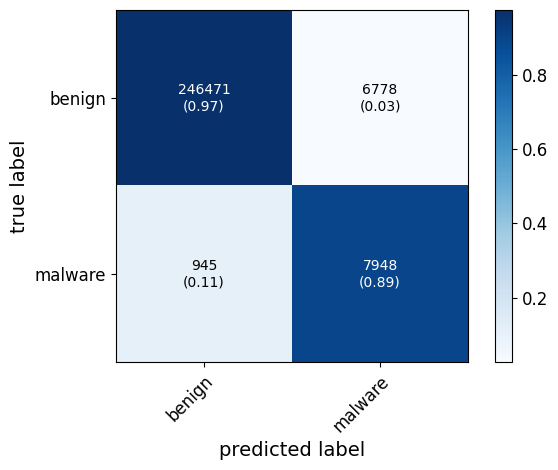

In [140]:
plot_cm(y_test, logreg_pred_test)
save_fig("logistic_regression_pred_test_confusion_matrix")
plt.show()

In [142]:
from scikitplot.metrics import plot_precision_recall

In [143]:
def plot_precision_recall_curve(y_test, y_pred, title):
    plot_precision_recall(y_test, y_pred, title=title)
    plt.title(title)

In [146]:
logreg_test_proba = logreg.predict_proba(X_test_scaled)

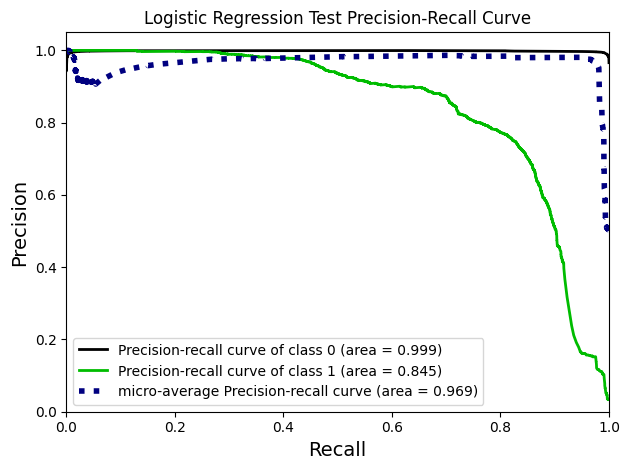

In [149]:
plot_precision_recall_curve(y_test, logreg_test_proba, title="Logistic Regression Test Precision-Recall Curve")
save_fig("logistic_regression_test_precision_recall_curve")
plt.show()

In [150]:
from scikitplot.metrics import plot_roc

In [151]:
def plot_roc_curve(y_test, y_pred, title):
    plot_roc(y_test, y_pred, title=title)
    plt.title(title)

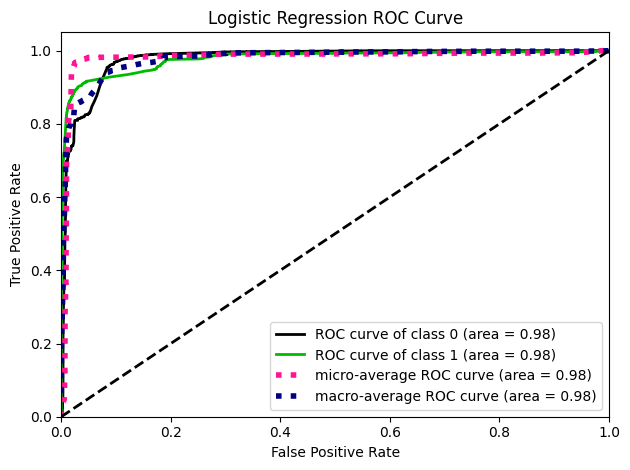

In [152]:
plot_roc_curve(y_test, logreg_test_proba, title="Logistic Regression ROC Curve")
save_fig("logistic_regression_roc_curve")
plt.show()

In [153]:
from scikitplot.metrics import plot_cumulative_gain

In [154]:
def plot_cumulative(y_test, y_pred, title):
    plot_cumulative_gain(y_test, y_pred, title=title)
    plt.title(title)

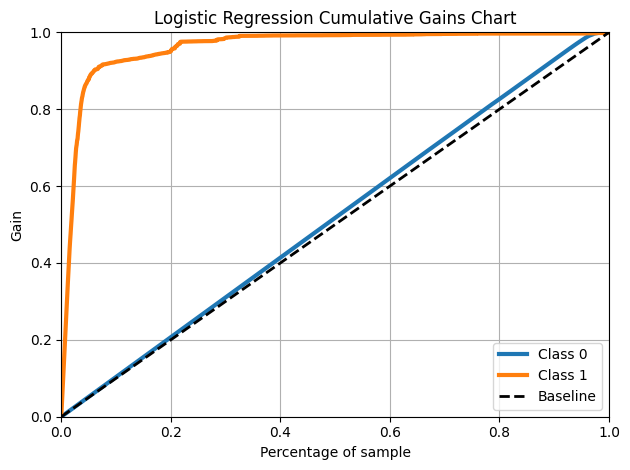

In [155]:
plot_cumulative_gain(y_test, logreg_test_proba, title="Logistic Regression Cumulative Gains Chart")
save_fig("logistic_regression_cumulative_gains")
plt.show()

# Random Forest

In [188]:
rf = RandomForestClassifier()
start = time.time()
rf.fit(X_train_scaled, y_res)
end = time.time()
rf_time = end - start
print("Random Forest Train Time:", rf_time)

Random Forest Train Time: 270.4351136684418


In [128]:
pickle.dump(rf, open("../models/rf.pkl", "wb"))

In [158]:
rf_scores = cross_val_score(rf, X_train_scaled, y_res, cv=3)
print("Random Forest Cross-Validation Accuracy Scores:\n", rf_scores)

Random Forest Cross-Validation Accuracy Scores:
 [0.96694433 0.96700649 0.96719311]


In [129]:
rf_pred_train = rf.predict(X_train_scaled)
rf_pred_test = rf.predict(X_test_scaled)

rf_train_score = accuracy_score(rf_pred_train, y_res)
rf_test_score = accuracy_score(rf_pred_test, y_test)
print("Random Forest Train Score:", rf_train_score)
print("Random Forest Test Score:", rf_test_score)

Random Forest Train Score: 0.9692857227481133
Random Forest Test Score: 0.9906462909415508


In [130]:
rf_precision_score = precision_score(y_test, rf_pred_test)
rf_f1_score = f1_score(y_test, rf_pred_test)
rf_recall_score = recall_score(y_test, rf_pred_test)
rf_accuracy_score = accuracy_score(y_test, rf_pred_test)

print("Random Forest Precision Score:", rf_precision_score)
print("Random Forest F1 Score:", rf_f1_score)
print("Random Forest Recall Score:", rf_recall_score)
print("Random Forest Accuracy Score:", rf_accuracy_score)

Random Forest Precision Score: 0.8272980501392758
Random Forest F1 Score: 0.8715154055753511
Random Forest Recall Score: 0.920726306465899
Random Forest Accuracy Score: 0.9906462909415508


In [131]:
print(classification_report(y_test, rf_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    253110
           1       0.83      0.92      0.87      9032

    accuracy                           0.99    262142
   macro avg       0.91      0.96      0.93    262142
weighted avg       0.99      0.99      0.99    262142



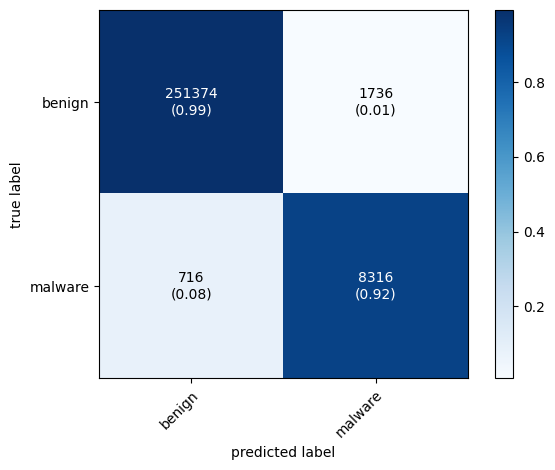

In [185]:
rf_cm = confusion_matrix(y_test, rf_pred_test)
plot_confusion_matrix(conf_mat=rf_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=["benign", "malware"])
save_fig("random_forest_pred_test_confusion_matrix")
plt.show()

In [140]:
rf_test_proba = rf.predict_proba(X_test_scaled)

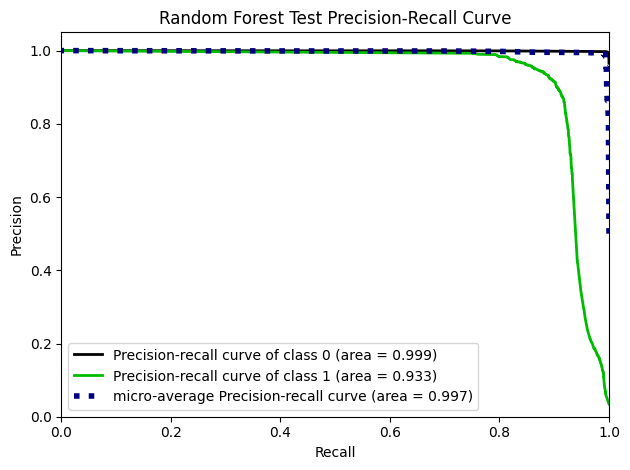

In [142]:
plot_precision_recall(y_test, rf_test_proba, title="Random Forest Test Precision-Recall Curve")
save_fig("random_forest_test_precision_recall_curve")
plt.show()

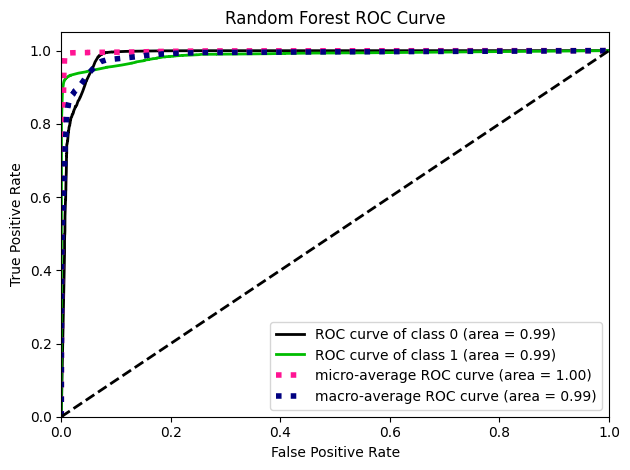

In [143]:
plot_roc_curve(y_test, rf_test_proba, title="Random Forest ROC Curve")
save_fig("random_forest_roc_curve")
plt.show()

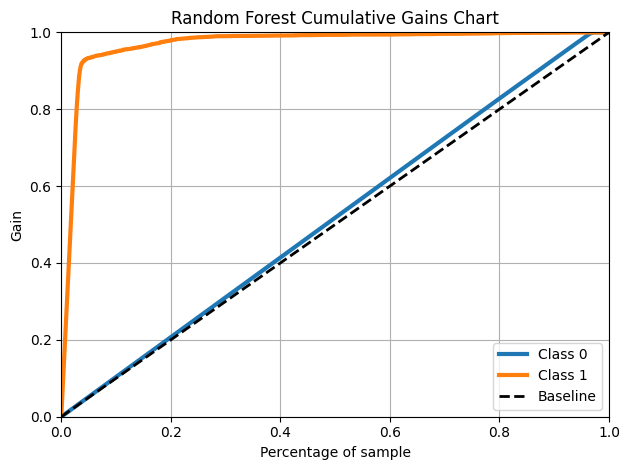

In [144]:
plot_cumulative_gain(y_test, rf_test_proba, title="Random Forest Cumulative Gains Chart")
save_fig("random_forest_cumulative_gains")
plt.show()

In [148]:
for name, score in zip(X.columns, rf.feature_importances_):
    print(name, score)

is_xss 0.0554067486032545
is_lfi 0.0011821629855717785
is_oci 0.04496607527086551
is_sqli 7.023623999539142e-05
url_len 0.22021541592141547
semicolon_count 0.004304895833438172
underscore_count 0.009020415963884297
questionmark_count 0.04685152191739183
equal_count 0.08695256819966096
and_count 0.06871568610835979
or_count 0.0019345690260019067
dot_count 0.05218544305640197
at_count 0.0021690010681181754
subdir_count 0.0203804103181572
query_len 0.022763044210406525
param_count 0.02776593926580451
total_digits_url 0.01916980057124916
total_letter_url 0.1709089052812923
total_digits_domain 0.002305958417789783
total_letter_domain 0.03615037925590328
total_digits_path 0.011976535071124807
total_letter_path 0.047992041042623425
has_extension 0.015173440793725314
has_parameter 0.03143880557756401


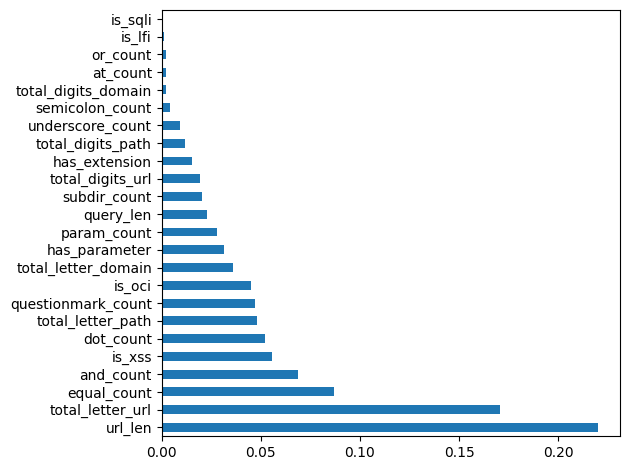

In [160]:
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.nlargest(30).plot(kind='barh')
save_fig("rf_feature_importances")
plt.show()

# Decision Tree

In [169]:
dt = DecisionTreeClassifier()
start = time.time()
dt.fit(X_train_scaled, y_res)
end = time.time()
dt_time = end - start
print("Decision Tree Train Time:", dt_time)

Decision Tree Train Time: 13.518588304519653


In [170]:
pickle.dump(dt, open("../models/dt.pkl", "wb"))

In [171]:
dt_scores = cross_val_score(dt, X_train_scaled, y_res, cv=3)
print("Decision Tree Cross-Validation Accuracy Scores:\n", dt_scores)

Decision Tree Cross-Validation Accuracy Scores:
 [0.96653109 0.96680802 0.96692651]


In [172]:
dt_pred_train = dt.predict(X_train_scaled)
dt_pred_test = dt.predict(X_test_scaled)

dt_train_score = accuracy_score(dt_pred_train, y_res)
dt_test_score = accuracy_score(dt_pred_test, y_test)
print("Decision Tree Train Score:", dt_train_score)
print("Decision Tree Test Score:", dt_test_score)

Decision Tree Train Score: 0.9683612360465863
Decision Tree Test Score: 0.990714956016205


In [173]:
dt_precision_score = precision_score(y_test, dt_pred_test)
dt_f1_score = f1_score(y_test, dt_pred_test)
dt_recall_score = recall_score(y_test, dt_pred_test)
dt_accuracy_score = accuracy_score(y_test, dt_pred_test)

print("Decision Tree Precision Score:", dt_precision_score)
print("Decision Tree F1 Score:", dt_f1_score)
print("Decision Tree Recall Score:", dt_recall_score)
print("Decision Tree Accuracy Score:", dt_accuracy_score)

Decision Tree Precision Score: 0.8289701538148111
Decision Tree F1 Score: 0.8699091394975949
Decision Tree Recall Score: 0.915101765433487
Decision Tree Accuracy Score: 0.990714956016205


In [174]:
print(classification_report(y_test, dt_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    253249
           1       0.83      0.92      0.87      8893

    accuracy                           0.99    262142
   macro avg       0.91      0.95      0.93    262142
weighted avg       0.99      0.99      0.99    262142



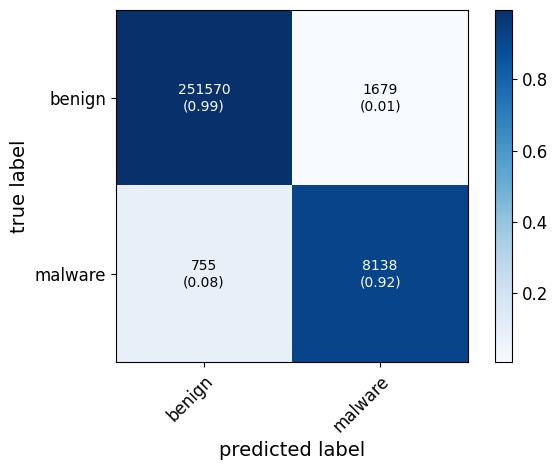

In [175]:
plot_cm(y_test, dt_pred_test)
save_fig("decision_tree_pred_test_confusion_matrix")
plt.show()

In [176]:
dt_test_proba = dt.predict_proba(X_test_scaled)

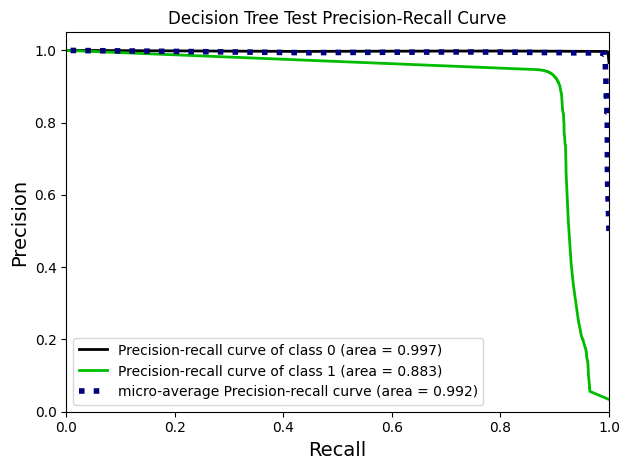

In [177]:
plot_precision_recall_curve(y_test, dt_test_proba, title="Decision Tree Test Precision-Recall Curve")
save_fig("decision_tree_test_precision_recall_curve")
plt.show()

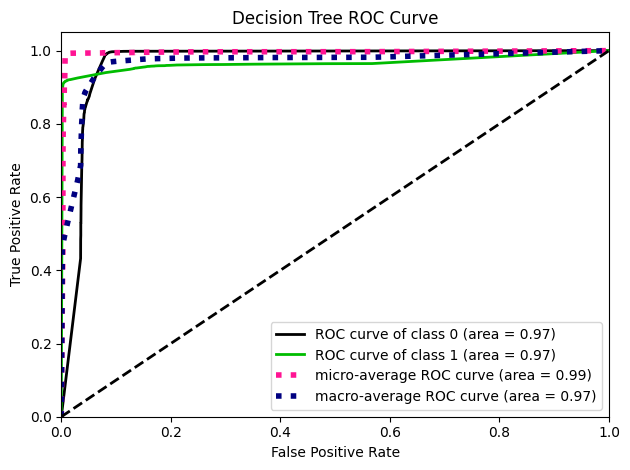

In [179]:
plot_roc_curve(y_test, dt_test_proba, title="Decision Tree ROC Curve")
save_fig("decision_tree_roc_curve")
plt.show()

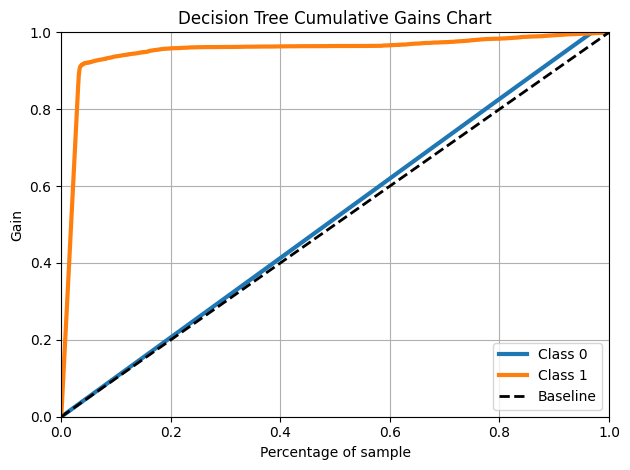

In [180]:
plot_cumulative_gain(y_test, dt_test_proba, title="Decision Tree Cumulative Gains Chart")
save_fig("decision_tree_cumulative_gains")
plt.show()

# XGBClassifier

In [181]:
xgb = XGBClassifier()
start = time.time()
xgb.fit(X_train_scaled, y_res)
end = time.time()
xgb_time = end - start
print("XGBClassifier Train Time:", xgb_time)

XGBClassifier Train Time: 81.23482584953308


In [182]:
pickle.dump(xgb, open("../models/xgb.pkl", "wb"))

In [183]:
xgb_scores = cross_val_score(xgb, X_train_scaled, y_res, cv=3)
print("XGBClassifier Cross-Validation Accuracy Scores:\n", xgb_scores)

XGBClassifier Cross-Validation Accuracy Scores:
 [0.96098874 0.96020961 0.96124195]


In [184]:
xgb_pred_train = xgb.predict(X_train_scaled)
xgb_pred_test = xgb.predict(X_test_scaled)

xgb_train_score = accuracy_score(xgb_pred_train, y_res)
xgb_test_score = accuracy_score(xgb_pred_test, y_test)
print("XGBClassifier Train Score:", xgb_train_score)
print("XGBClassifier Test Score:", xgb_test_score)

XGBClassifier Train Score: 0.9613752721563671
XGBClassifier Test Score: 0.9857901442729513


In [185]:
xgb_precision_score = precision_score(y_test, xgb_pred_test)
xgb_f1_score = f1_score(y_test, xgb_pred_test)
xgb_recall_score = recall_score(y_test, xgb_pred_test)
xgb_accuracy_score = accuracy_score(y_test, xgb_pred_test)

print("XGBClassifier Precision Score:", xgb_precision_score)
print("XGBClassifier F1 Score:", xgb_f1_score)
print("XGBClassifier Recall Score:", xgb_recall_score)
print("XGBClassifier Accuracy Score:", xgb_accuracy_score)

XGBClassifier Precision Score: 0.7257951765117092
XGBClassifier F1 Score: 0.8168363082067169
XGBClassifier Recall Score: 0.9339930282244462
XGBClassifier Accuracy Score: 0.9857901442729513


In [186]:
print(classification_report(y_test, xgb_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    253249
           1       0.73      0.93      0.82      8893

    accuracy                           0.99    262142
   macro avg       0.86      0.96      0.90    262142
weighted avg       0.99      0.99      0.99    262142



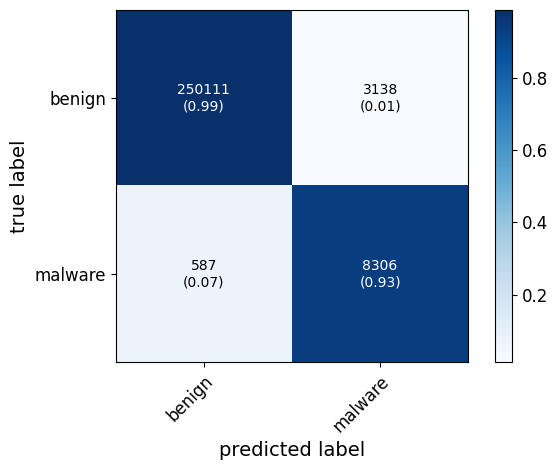

In [187]:
plot_cm(y_test, xgb_pred_test)
save_fig("xgb_pred_test_confusion_matrix")
plt.show()

In [188]:
xgb_test_proba = xgb.predict_proba(X_test_scaled)

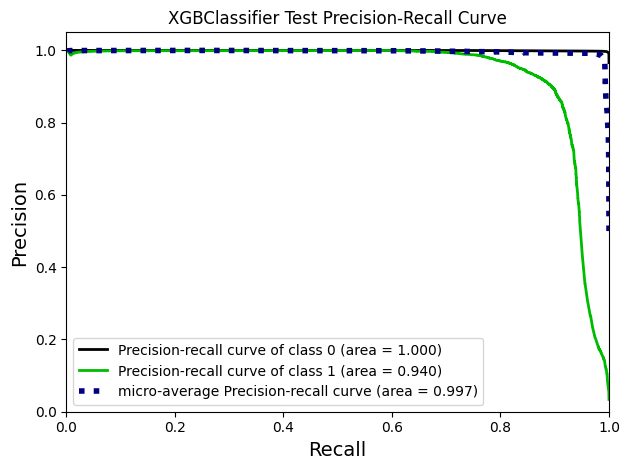

In [190]:
plot_precision_recall_curve(y_test, xgb_test_proba, title="XGBClassifier Test Precision-Recall Curve")
save_fig("xgb_test_precision_recall_curve")
plt.show()

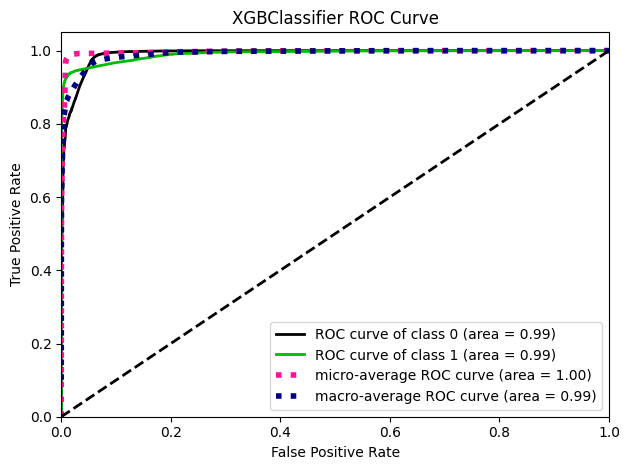

In [191]:
plot_roc_curve(y_test, xgb_test_proba, title="XGBClassifier ROC Curve")
save_fig("xgb_roc_curve")
plt.show()

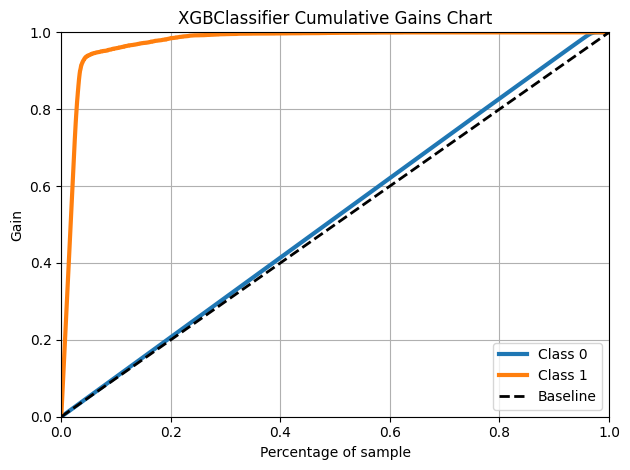

In [192]:
plot_cumulative(y_test, xgb_test_proba, title="XGBClassifier Cumulative Gains Chart")
save_fig("xgb_cumulative_gains")
plt.show()

In [231]:
labels = ["LR", "DT", "RF", "XGB"]
scores = [logreg_test_score, dt_test_score, rf_test_score, xgb_test_score]

In [229]:
def plot_model_plot(labels, scores):
    plt.figure()
    ax = sns.barplot(x=labels, y=scores)
    ax.set_title("Trained Models Accuracy")
    for container in ax.containers:
        ax.bar_label(container)

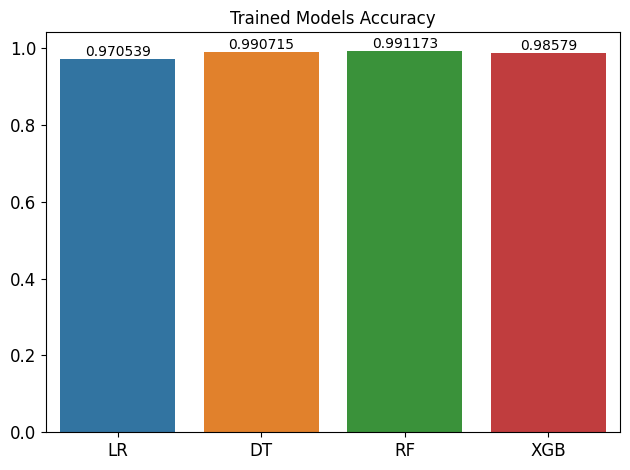

In [230]:
plot_model_plot(labels, scores)
save_fig("trained_models")
plt.show()

In [173]:
df.head()

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,...,url_tokenized,url_stemmed,total_digits_domain,total_letter_domain,total_digits_path,total_letter_path,has_extension,extension,has_parameter,parameters
0,komport,0,0,0,0,0,7,0,0,0,...,[komport],komport,0,0,0,7,0,,0,
1,qlaunch,0,0,0,0,0,7,0,0,0,...,[qlaunch],qlaunch,0,0,0,7,0,,0,
2,nowi_uzytkownicy1,0,0,0,0,0,17,0,1,0,...,"[nowi, uzytkownicy]",nowi uzytkownici,0,0,1,15,0,,0,
3,118438,0,0,0,0,0,6,0,0,0,...,[],,0,0,6,0,0,,0,
4,mainfrme,0,0,0,0,0,8,0,0,0,...,[mainfrme],mainfrm,0,0,0,8,0,,0,


# Test

In [484]:
columns = ['query', 'is_xss', 'is_lfi', 'is_oci', 'is_sqli', 'url_len',
       'semicolon_count', 'underscore_count', 'questionmark_count',
       'equal_count', 'and_count', 'or_count', 'dot_count', 'at_count',
       'subdir_count', 'query_len', 'param_count', 'total_digits_url',
       'total_letter_url', 'total_digits_domain', 'total_letter_domain', 
       'total_digits_path', 'total_letter_path', 'has_extension', 'has_parameter']

In [498]:
test1 = 'hrttz9fj.dll?<script>document.cookie="testtbjy=7334;"</script>' # 1
test2 = 'index.php?option=com_mailto&tmpl=component&link=aHR0cDovL2FkdmVudHVyZ' # 1
test3 = 'nba/player/_/id/3457/brandon-rush' # 0
test4 = '?q=anthony-hamilton-soulife' # 0
test5 = 'site/relationship_detail.php?name=Martin-Brodeur&celebid=12150&relid=11371' # 0

In [499]:
test_df = pd.DataFrame(columns=columns)

In [500]:
test_df.loc[0, "query"] = test1
test_df.loc[1, "query"] = test2
test_df.loc[2, "query"] = test3
test_df.loc[3, "query"] = test4
test_df.loc[4, "query"] = test5

In [501]:
test_df.head()

,query,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,equal_count,...,query_len,param_count,total_digits_url,total_letter_url,total_digits_domain,total_letter_domain,total_digits_path,total_letter_path,has_extension,has_parameter
0,"hrttz9fj.dll?<script>document.cookie=""testtbjy...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,index.php?option=com_mailto&tmpl=component&lin...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,nba/player/_/id/3457/brandon-rush/q=/etc/passwd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,?q=anthony-hamilton-soulife,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,site/relationship_detail.php?name=Martin-Brode...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [502]:
stemmer = SnowballStemmer("english")
tokenizer = RegexpTokenizer(r"[A-Za-z]+")

In [503]:
def preprocess(test_df):
    test_df["query"] = test_df["query"].apply(clear_first_char)
    test_df["is_xss"] = test_df["query"].apply(xss_check)
    test_df["is_lfi"] = test_df["query"].apply(lfi_check)
    test_df["is_oci"] = test_df["query"].apply(command_injection_check)
    test_df["is_sqli"] = test_df["query"].apply(sql_injection_check)
    test_df["url_len"] = test_df["query"].apply(urllen)
    test_df["semicolon_count"] = test_df["query"].apply(semicolon_count)
    test_df["underscore_count"] = test_df["query"].apply(underscore_count)
    test_df["questionmark_count"] = test_df["query"].apply(questionmark_count)
    test_df["equal_count"] = test_df["query"].apply(equal_count)
    test_df["and_count"] = test_df["query"].apply(and_count)
    test_df["or_count"] = test_df["query"].apply(or_count)
    test_df["dot_count"] = test_df["query"].apply(dotcount)
    test_df["at_count"] = test_df["query"].apply(atcount)
    test_df["subdir_count"] = test_df["query"].apply(subdircount)
    test_df["query_len"] = test_df["query"].apply(query_len)
    test_df["param_count"] = test_df["query"].apply(param_count)
    test_df["total_digits_url"] = test_df["query"].apply(total_digits_in_url)
    test_df["total_letter_url"] = test_df["query"].apply(total_letter_in_url)
    test_df["url_tokenized"] = test_df["query"].apply(lambda x: tokenizer.tokenize(x))
    test_df["url_stemmed"] = test_df["url_tokenized"].apply(stem_url)
    test_df["total_digits_domain"] = test_df["query"].apply(total_digits_domain)
    test_df["total_letter_domain"] = test_df["query"].apply(total_letter_domain)
    test_df["total_digits_path"] = test_df["query"].apply(total_digits_path)
    test_df["total_letter_path"] = test_df["query"].apply(total_letter_path)
    test_df["has_extension"] = test_df["query"].apply(has_extension)
    test_df["extension"] = test_df["query"].apply(find_extension)
    test_df["has_parameter"] = test_df["query"].apply(has_parameter)
    test_df["parameters"] = test_df["query"].apply(find_parameter_name)
    return test_df

In [504]:
test_df = preprocess(test_df)

In [505]:
test_df.head()

,query,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,equal_count,...,total_digits_domain,total_letter_domain,total_digits_path,total_letter_path,has_extension,has_parameter,url_tokenized,url_stemmed,extension,parameters
0,"hrttz9fj.dll?<script>document.cookie=""testtbjy...",1,0,1,0,62,1,0,1,2,...,0,0,1,10,1,1,"[hrttz, fj, dll, script, document, cookie, tes...",hrttz dll script document cooki testtbji script,.dll,<script>document.cookie
1,index.php?option=com_mailto&tmpl=component&lin...,0,0,0,0,69,0,1,1,3,...,0,0,0,8,1,1,"[index, php, option, com, mailto, tmpl, compon...",index php option com mailto tmpl compon link a...,.php,option tmpl link
2,nba/player/_/id/3457/brandon-rush/q=/etc/passwd,0,0,0,0,47,0,1,0,1,...,4,26,0,6,0,0,"[nba, player, id, brandon, rush, q, etc, passwd]",nba player brandon rush etc passwd,,
3,?q=anthony-hamilton-soulife,0,0,0,0,27,0,0,1,1,...,0,0,0,0,0,1,"[q, anthony, hamilton, soulife]",anthoni hamilton soulif,,q
4,site/relationship_detail.php?name=Martin-Brode...,0,0,0,0,74,0,1,1,3,...,0,4,0,21,1,1,"[site, relationship, detail, php, name, Martin...",site relationship detail php name martin brode...,.php,name celebid relid


In [506]:
dropped = test_df.drop(["query", "url_tokenized", "url_stemmed", "extension", "parameters"], axis=1)

In [507]:
dropped_scaled = ss.transform(dropped)

In [508]:
logreg.predict(dropped_scaled)

array([1, 0, 0, 0, 0])